# WeatherPy
----

### Analysis
* As most pepole are aware, the weather becomes significantly warmer as one approaches the equator (0 Deg. Latitude). 
* For cities equi-distant from the equator however, the southern hemisphere is much warmer than it's northern hemisphere counter parts, given that the southern hemispehere at this time of year is in summer while the northern hemisphere is in winter. The Earths tilt is the reason why the seasons are reversed in the southern hemisphere.

* There is no strong relationship between latitude and humidity, but while we see high humidty at the equator and for cities equidistant of +/- 100 latitude, for those cities close to the equator there are no observations where the humidity is 0. 

* There is no strong relationship between latitude and cloudiness. 

* There is no strong relationship between latitude and wind speed.


In [1]:
import os
os.mkdir('./images')
os.mkdir('./output_data')

In [6]:
pip install citipy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.7/557.7 KB 6.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for citipy: filename=citipy-0.0.5-py3-none-any.whl size=559700 sha256=6f1168d124fe0954a108ae173a1ec50c294785b4054df7e83723da5124dd15fc
  Stored in directory: /home/ec2-user/.cache/pip/wheels/6d/df/5e/ad8eb9cc5ee7f4ba76865167c09f9a7edff405c669111d8353
Successfully built citipy
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install s3pathlib

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 KB 613.3 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 34.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.19
    Uninstalling botocore-1.24.19:
      Successfully uninstalled botocore-1.24.19
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.25.48 requires botocore==1.27.48, but you have botocore 1.27.57 which is incompatible.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.27.57 which is incompatible.
You should consider upgrading via 

In [7]:
%matplotlib inline

# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import datetime
import boto3
from s3pathlib import S3Path

# Import API key
from api_keys import api_key

# Import S3 keys
from s3 import AWSAccessKeyId, AWSSecretKey

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

## Generate Cities List

In [8]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=2000)
lngs = np.random.uniform(low=-180.000, high=180.000, size=2000)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

731

In [9]:
cities

['cherskiy',
 'tasiilaq',
 'gibara',
 'butaritari',
 'nipawin',
 'todos santos',
 'churapcha',
 'rikitea',
 'ostrovnoy',
 'vaini',
 'upernavik',
 'saint-pierre',
 'nikolskoye',
 'bredasdorp',
 'inongo',
 'hermanus',
 'port alfred',
 'sorvag',
 'cabo san lucas',
 'saint anthony',
 'punta arenas',
 'mataura',
 'manzil salim',
 'qaanaaq',
 'kodiak',
 'talnakh',
 'guiratinga',
 'atuona',
 'bonthe',
 'mount gambier',
 'cape town',
 'deputatskiy',
 'jumla',
 'poum',
 'erie',
 'nayagarh',
 'sao filipe',
 'yatou',
 'mergui',
 'saint george',
 'hilo',
 'carnarvon',
 'kruisfontein',
 'taphan hin',
 'nizhneyansk',
 'seidu',
 'sitio novo do tocantins',
 'longyearbyen',
 'barrow',
 'abu samrah',
 'faanui',
 'busselton',
 'ushuaia',
 'isangel',
 'mar del plata',
 'albany',
 'grand river south east',
 'tungor',
 'victoria',
 'san jeronimo',
 'khandyga',
 'oriximina',
 'namibe',
 'thompson',
 'okhotsk',
 'aklavik',
 'east london',
 'abonnema',
 'hobart',
 'harper',
 'muros',
 'boende',
 'ontario',
 'c

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [10]:
"""
Function that prints out a message banner

param1: decoration: a single char to use as the header and footer banner 
param2: message: the message to display

"""
def print_banner(decoration, message):
    print(decoration * len(message))
    print(message)
    print(decoration * len(message))

In [11]:
"""
Function to build the url by city name

param1: city_name: the cityname

returns: the fully formed url for the OpenWeatherMap API with the api_key and the city_name and units as imperial as query params
"""
def build_url_by_city_name(city_name):
    base_url = f'http://api.openweathermap.org/data/2.5/weather?appid={api_key}'
    return f"{base_url}&q={city_name}&units=imperial"

In [12]:
#Create an empty list
l = []

start_msg = 'Beginning Data Retrieval'
end_msg = 'Data Retrieval Complete'
interrupt_msg = 'Stopped processing at the request of the user'

print_banner(decoration='-', message=start_msg)

batch_size = 60
wait_time = 1
record_number = 0
record_group_number = 0

try:
    for i in range(0, len(cities), batch_size):
        record_group_number = record_group_number + 1
        print_banner(decoration='o', message=datetime.datetime.now().strftime('%m/%d/%Y %r'))
        for j in range(i, batch_size + i): 
            #sleep for 1 second per api call
            time.sleep(wait_time)                
           
            if j < len(cities):
                record_number = j + 1
                json_data = requests.get(build_url_by_city_name(cities[j])).json()
                if json_data['cod'] == '404':
                    print(f"Processing Record {record_number} of Set {record_group_number} | City not found. Skipping {cities[j]} ...") 
                else:
                    print(f"Processing Record {record_number} of Set {record_group_number} | {json_data['name']}")
                    #Create an empty dictionary to store what we want from the json_data 
                    d = {}
                    d['id'] = json_data['id']
                    d['City'] = json_data['name']
                    d['Country'] = json_data['sys']['country']
                    d['Date'] = json_data['dt']
                    d['Humidity'] = json_data['main']['humidity']
                    d['Lat'] = json_data['coord']['lat']
                    d['Lng'] = json_data['coord']['lon']
                    d['Cloudiness'] = json_data['clouds']['all']
                    d['Max Temp'] = json_data['main']['temp_max']
                    d['Wind Speed'] = json_data['wind']['speed']
                    l.append(d)

except KeyboardInterrupt:
    print_banner(decoration='*', message=interrupt_msg)
except KeyError:
    if type(json_data) == dict:
        print(f"ERROR: {json_data['cod']}: {json_data['message']}")
    else:
        print('Something went wrong')
finally:  
    print_banner(decoration='-', message=end_msg)
    print_banner(decoration='o', message=datetime.datetime.now().strftime('%m/%d/%Y %r'))

------------------------
Beginning Data Retrieval
------------------------
oooooooooooooooooooooo
08/23/2022 01:02:28 PM
oooooooooooooooooooooo
Processing Record 1 of Set 1 | Cherskiy
Processing Record 2 of Set 1 | Tasiilaq
Processing Record 3 of Set 1 | Gibara
Processing Record 4 of Set 1 | Butaritari
Processing Record 5 of Set 1 | Nipawin
Processing Record 6 of Set 1 | Todos Santos
Processing Record 7 of Set 1 | Churapcha
Processing Record 8 of Set 1 | Rikitea
Processing Record 9 of Set 1 | Ostrovnoy
Processing Record 10 of Set 1 | Vaini
Processing Record 11 of Set 1 | Upernavik
Processing Record 12 of Set 1 | Saint-Pierre
Processing Record 13 of Set 1 | Nikolskoye
Processing Record 14 of Set 1 | Bredasdorp
Processing Record 15 of Set 1 | Inongo
Processing Record 16 of Set 1 | Hermanus
Processing Record 17 of Set 1 | Port Alfred
Processing Record 18 of Set 1 | City not found. Skipping sorvag ...
Processing Record 19 of Set 1 | Cabo San Lucas
Processing Record 20 of Set 1 | Saint Anth

Processing Record 179 of Set 3 | Cross Lanes
Processing Record 180 of Set 3 | City not found. Skipping bolungarvik ...
oooooooooooooooooooooo
08/23/2022 01:06:25 PM
oooooooooooooooooooooo
Processing Record 181 of Set 4 | City not found. Skipping kollumerland ...
Processing Record 182 of Set 4 | Scarborough
Processing Record 183 of Set 4 | Flin Flon
Processing Record 184 of Set 4 | Rovaniemi
Processing Record 185 of Set 4 | Naze
Processing Record 186 of Set 4 | Evensk
Processing Record 187 of Set 4 | City not found. Skipping illoqqortoormiut ...
Processing Record 188 of Set 4 | Constitución
Processing Record 189 of Set 4 | Guiyang
Processing Record 190 of Set 4 | Hofn
Processing Record 191 of Set 4 | Namtsy
Processing Record 192 of Set 4 | Ulaangom
Processing Record 193 of Set 4 | Cascais
Processing Record 194 of Set 4 | City not found. Skipping karaul ...
Processing Record 195 of Set 4 | Palembang
Processing Record 196 of Set 4 | Clyde River
Processing Record 197 of Set 4 | Lázaro Cárd

Processing Record 357 of Set 6 | City not found. Skipping saleaula ...
Processing Record 358 of Set 6 | Batagay
Processing Record 359 of Set 6 | Nuristan
Processing Record 360 of Set 6 | Butembo
oooooooooooooooooooooo
08/23/2022 01:10:18 PM
oooooooooooooooooooooo
Processing Record 361 of Set 7 | Ilulissat
Processing Record 362 of Set 7 | Hersbruck
Processing Record 363 of Set 7 | Airai
Processing Record 364 of Set 7 | Zhangzhou
Processing Record 365 of Set 7 | Ballina
Processing Record 366 of Set 7 | Zapolyarnyy
Processing Record 367 of Set 7 | Riviere-au-Renard
Processing Record 368 of Set 7 | Nouadhibou
Processing Record 369 of Set 7 | Pringsewu
Processing Record 370 of Set 7 | Pisco
Processing Record 371 of Set 7 | Salalah
Processing Record 372 of Set 7 | Muhafazat Lahij
Processing Record 373 of Set 7 | Turaif
Processing Record 374 of Set 7 | Trairi
Processing Record 375 of Set 7 | Robertsport
Processing Record 376 of Set 7 | Greensboro
Processing Record 377 of Set 7 | São José da C

Processing Record 539 of Set 9 | City not found. Skipping falealupo ...
Processing Record 540 of Set 9 | Port-Cartier
oooooooooooooooooooooo
08/23/2022 01:14:16 PM
oooooooooooooooooooooo
Processing Record 541 of Set 10 | Sola
Processing Record 542 of Set 10 | Shakawe
Processing Record 543 of Set 10 | Praia da Vitória
Processing Record 544 of Set 10 | Kodinsk
Processing Record 545 of Set 10 | Verkhovyna
Processing Record 546 of Set 10 | Lubumbashi
Processing Record 547 of Set 10 | Keshabpur
Processing Record 548 of Set 10 | Vetluga
Processing Record 549 of Set 10 | Sūsangerd
Processing Record 550 of Set 10 | Havre-St-Pierre
Processing Record 551 of Set 10 | São Miguel
Processing Record 552 of Set 10 | Mehamn
Processing Record 553 of Set 10 | Lamu
Processing Record 554 of Set 10 | Koson
Processing Record 555 of Set 10 | Kolpashevo
Processing Record 556 of Set 10 | Patnongon
Processing Record 557 of Set 10 | Camacha
Processing Record 558 of Set 10 | Yazd
Processing Record 559 of Set 10 | 

Processing Record 716 of Set 12 | Mbandaka
Processing Record 717 of Set 12 | Ixtlahuacán del Río
Processing Record 718 of Set 12 | São Miguel do Tapuio
Processing Record 719 of Set 12 | Vanimo
Processing Record 720 of Set 12 | Calvinia
oooooooooooooooooooooo
08/23/2022 01:18:14 PM
oooooooooooooooooooooo
Processing Record 721 of Set 13 | Tanout
Processing Record 722 of Set 13 | Maraã
Processing Record 723 of Set 13 | Eydhafushi
Processing Record 724 of Set 13 | Tygda
Processing Record 725 of Set 13 | Suez
Processing Record 726 of Set 13 | Alta Floresta
Processing Record 727 of Set 13 | Cookeville
Processing Record 728 of Set 13 | City not found. Skipping umzimvubu ...
Processing Record 729 of Set 13 | Sukhobezvodnoye
Processing Record 730 of Set 13 | Viedma
Processing Record 731 of Set 13 | Yārāda
-----------------------
Data Retrieval Complete
-----------------------
oooooooooooooooooooooo
08/23/2022 01:19:20 PM
oooooooooooooooooooooo


In [13]:
"""
Function that Uploads a file to S3
param1: file_name: a file on the local filesystem 
param2: bucket_name: the s3 bucket name
param3: folder: the subfolder in s3
"""

def s3_upload(file_name, bucket_name = 'bal-ddcruz', folder = 'staging'):
    #Creating Session With Boto3.
    session = boto3.Session(aws_access_key_id = AWSAccessKeyId, aws_secret_access_key = AWSSecretKey)

    #Creating S3 Resource From the Session.
    s3 = session.resource('s3')

    #object = s3.Object(bucket_name, f"/{folder}/{file_name}")
    object = s3.Object(bucket_name, f"{folder}/{file_name}")

    result = object.put(Body=open(f'./{file_name}', 'rb'))
    
    res = result.get('ResponseMetadata')

    if res.get('HTTPStatusCode') == 200:
        print(f'{file_name} Uploaded Successfully')
    else:
        print('File Not Uploaded')
        
    #return res

### Convert Raw Data to DataFrame
* Export the city data into a .csv and uploade to s3
* Display the DataFrame

In [14]:
# Output File (CSV)
#output_data_file = f"cities_{datetime.datetime.now().strftime('%Y_%d_%m_%H_%M_%S')}.csv"
output_data_file = './output_data/cities.csv'

df = pd.DataFrame(l)
df.to_csv(f"./{output_data_file}", index=False)
#df = pd.read_csv(output_data_file)
s3_upload(file_name = output_data_file)
df.head()

./output_data/cities.csv Uploaded Successfully


,id,City,Country,Date,Humidity,Lat,Lng,Cloudiness,Max Temp,Wind Speed
0,2126199,Cherskiy,RU,1661259749,73,68.7500,161.3000,100,56.07,7.72
1,3424607,Tasiilaq,GL,1661259751,69,65.6145,-37.6368,92,46.56,5.64
2,3558315,Gibara,CU,1661259752,70,21.1097,-76.1317,64,83.66,10.18
3,2110227,Butaritari,KI,1661259753,69,3.0707,172.7902,100,82.17,19.08
4,6088469,Nipawin,CA,1661259754,83,53.3668,-104.0009,0,55.44,6.91


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [15]:
"""
Function to build the scatter plot based on the param values passed in

param1: x_axis
param2: y_axis
param3: title
param4: xlabel
param5. ylabel

"""
def build_scatter_plot(x_axis, y_axis, title, xlabel, ylabel):
    todays_date = datetime.date.today().strftime('%m/%d/%Y')
    plt.scatter(x=x_axis, y=y_axis, alpha=.75, edgecolors='black', linewidths=.75)
    plt.title(f"{title} ({todays_date})")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

#### Latitude vs. Temperature Plot

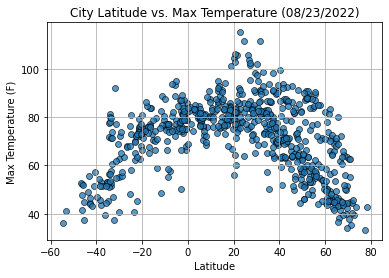

In [16]:
build_scatter_plot(x_axis=df['Lat']
                   , y_axis=df['Max Temp']
                   , title='City Latitude vs. Max Temperature'
                   , xlabel='Latitude'
                   , ylabel='Max Temperature (F)'
                  )  

# Save Figure
plt.savefig("./images/WeatherPy_latitude_v_max_temperature.png")

# Show Figure
plt.show()

#### Latitude vs. Humidity Plot

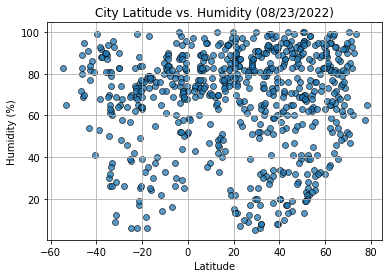

In [17]:
build_scatter_plot(x_axis=df['Lat']
                   , y_axis=df['Humidity']
                   , title='City Latitude vs. Humidity'
                   , xlabel='Latitude'
                   , ylabel='Humidity (%)'
                  )
# Save Figure
plt.savefig("./images/WeatherPy_latitude_v_humidity.png")

# Show Figure
plt.show()

#### Latitude vs. Cloudiness Plot

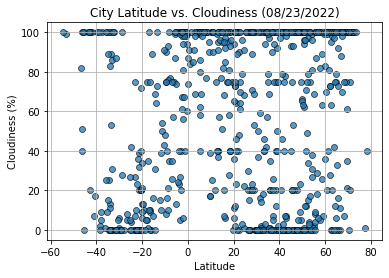

In [18]:
build_scatter_plot(x_axis=df['Lat']
                   , y_axis=df['Cloudiness']
                   , title='City Latitude vs. Cloudiness'
                   , xlabel='Latitude'
                   , ylabel='Cloudiness (%)'
                  ) 
# Save Figure
plt.savefig("./images/WeatherPy_latitude_v_cloudiness.png")

# Show Figure
plt.show()

#### Latitude vs. Wind Speed Plot

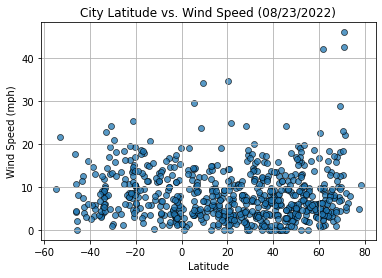

In [19]:
build_scatter_plot(x_axis=df['Lat']
                   , y_axis=df['Wind Speed']
                   , title='City Latitude vs. Wind Speed'
                   , xlabel='Latitude'
                   , ylabel='Wind Speed (mph)'
                  )  
# Save Figure
plt.savefig("./images/WeatherPy_latitude_v_wind_speed.png")

# Show Figure
plt.show()

## Data supporting observations and trends

#### for those cities close to the equator there are no observations where the humidity is 0

In [20]:
df[(df['Lat'] >= -2) & (df['Lat'] <= 2)]

,id,City,Country,Date,Humidity,Lat,Lng,Cloudiness,Max Temp,Wind Speed
14,2315417,Inongo,CD,1661259767,72,-1.9500,18.2667,56,73.40,1.81
57,3393471,Oriximiná,BR,1661259826,68,-1.7656,-55.8661,100,80.46,1.45
67,218680,Boende,CD,1661259839,51,-0.2167,20.8667,94,85.87,5.23
103,1282256,Hithadhoo,MV,1661259889,74,-0.6000,73.0833,99,82.26,15.39
119,3652764,Puerto Ayora,EC,1661259915,96,-0.7393,-90.3518,100,66.54,8.01
158,212730,Kisangani,CD,1661259972,59,0.5167,25.2000,91,82.44,4.88
210,3652758,Puerto Baquerizo Moreno,EC,1661260047,85,-0.9000,-89.6000,100,68.02,11.54
252,1637001,Biak,ID,1661260111,82,-0.9131,122.8766,99,74.97,7.40
284,1626542,Sorong,ID,1661260151,82,-0.8833,131.2500,100,78.80,3.22
321,3401148,Cururupu,BR,1661260203,50,-1.8283,-44.8683,100,87.17,6.67
